## Bootstrap and t-test project

Имеется таблица с результатами A/B-теста. В числовой колонке показаны значения выручки по каждому пользователю за период эксперимента.

Описание колонок: 
- *value* – значения метрики
- *experimentVariant* – вариант теста (Control – контроль, Treatment – тест)

**Задача:**  выяснить стали ли мы больше зарабатывать с пользователя или нет; понять какой статистический тест лучше применять на имеющихся данных - t-тест, U-тест, бутстрап средних

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np 
import scipy.stats as ss
import statsmodels.api as sm
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

%matplotlib inline

In [2]:
# Настроим отображение графиков
sns.set_theme(font_scale = 1, 
              style = 'whitegrid', 
              rc = {'figure.figsize': (10, 5)}
)

In [3]:
# Загрузим данные с ЯндексДиска
url = 'https://disk.yandex.ru/d/FPMcY4_9kTUpNg'
data = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{url}', sep=';', index_col=0)
data.head()

,value,experimentVariant
1,"10,3804953740268",Control
2,"9,54686666784264",Control
3,"11,0882146509904",Control
4,"10,1472740570122",Control
5,"9,78980767524929",Control


In [4]:
data.shape

(1000, 2)

In [5]:
data.experimentVariant.unique()

array(['Control', 'Treatment'], dtype=object)

In [6]:
# Приведем данные к нужному формату
data.value = data.value.apply(lambda x: float(x.replace(',', '.')))
data.dtypes

value                float64
experimentVariant     object
dtype: object

---

## t-test

Для начала сравним средние при помощи t-теста

Для успешного t-теста необходимо 
- нормальное распределение данных (при условии, что у нас n>30, этим условием можно и принебречь, так как распределение выборочных средних все равно будет стремиться к нормальному, согласно ЦПТ)
- приблиизительное равенство дисперсий 
- приблизительное равенство выборок 

In [7]:
# Создадим отдельные переменные для данных двух групп
control = data.query('experimentVariant == "Control"').value
treatment = data.query('experimentVariant == "Treatment"').value

Text(0.5, 1.0, 'Control_group\n')

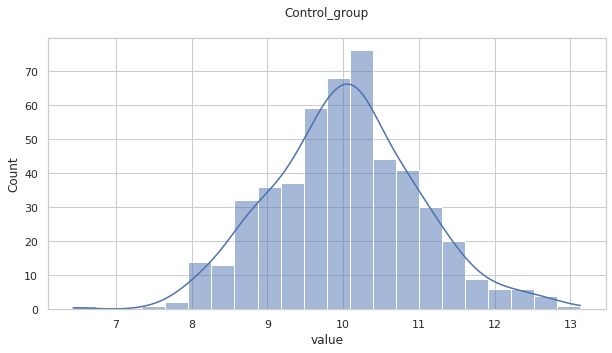

In [8]:
# Проверим нормальность распределения в группах при помощи теста Агостино-Пирсона по функции
# scipy.stats.normaltest()
ax = sns.histplot(control, kde = True)
ax.set_title('Control_group\n')

In [9]:
ss.normaltest(control) 
# Визуально и, согласно тесту, распределение данных в контрольной группе- нормальное 

NormaltestResult(statistic=2.943458720256407, pvalue=0.2295282048395919)

Text(0.5, 1.0, 'Treatment_group\n')

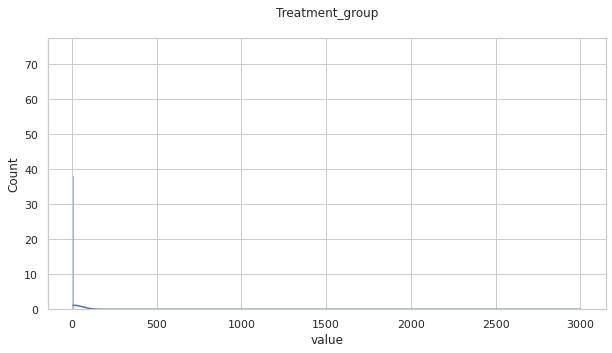

In [10]:
ax = sns.histplot(treatment, kde = True)
ax.set_title('Treatment_group\n') 
# Распределение данных в тестовой группе выглядит сильно скошенным вправо

Text(0.5, 1.0, 'Treatment_group_log\n')

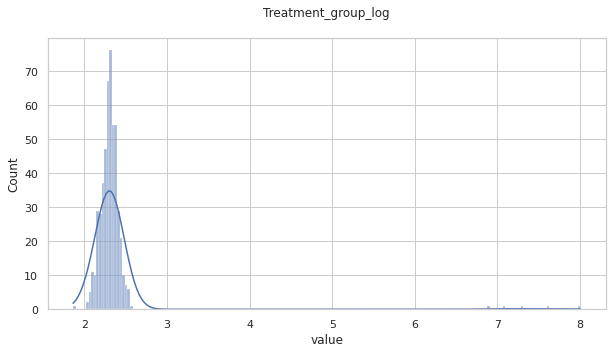

In [11]:
ax = sns.histplot(np.log(treatment), kde = True)
ax.set_title('Treatment_group_log\n')
# Даже логорифмирование не сильно помогло...

Text(0.5, 1.0, 'Treatment_group_no_outliers\n')

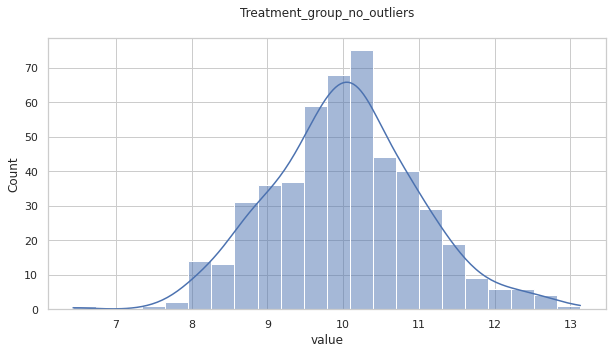

In [12]:
# Попробуем избаваиться от выбросов, взяв значения только из 99 перцентиля
treatment_cutted = data.query('experimentVariant == "Treatment"')
treatment_cutted = treatment_cutted[treatment_cutted.value <= treatment_cutted.value.quantile(0.99)]
treatment_cutted = treatment_cutted.value
ax = sns.histplot(treatment_cutted, kde = True)
ax.set_title('Treatment_group_no_outliers\n')
# Вся проблема была в небольшом количестве выбросов. Когда мы от них избавились, 
# распределение приняло нормальный вид

In [13]:
ss.normaltest(treatment)
# Тест Агостино-Пирсона показывает, что у нас нет оснований для отклонения гипотезы
# о нормальности распределения данных в тестовой группе. Судя по всему, выбросы не повлияли на резлультаты теста

NormaltestResult(statistic=929.5157667884811, pvalue=1.439513760946726e-202)

In [14]:
# Проверим, что количество наблюдений в обоих группах одинаково
data.groupby('experimentVariant', as_index=False).agg(count = ('value', 'count'))

,experimentVariant,count
0,Control,500
1,Treatment,500


In [15]:
# Проверим однородность стандартных отклонений в двух выборках
data.groupby('experimentVariant', as_index=False).agg(std = ('value', 'std'))

,experimentVariant,std
0,Control,0.979377
1,Treatment,186.557011


In [16]:
# Посмотрим на среднее в двух группах
data.groupby('experimentVariant', as_index=False).agg(mean = ('value', 'mean'))

,experimentVariant,mean
0,Control,10.026867
1,Treatment,27.321499


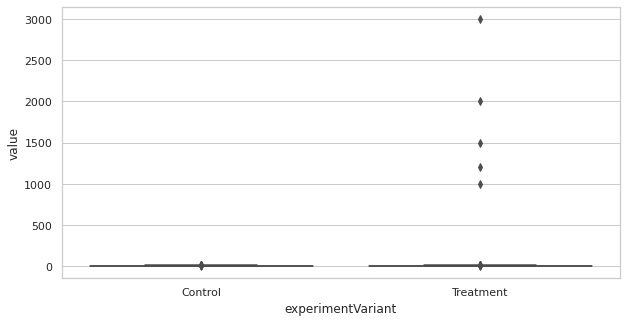

In [17]:
sns.boxplot(data=data, x='experimentVariant', y='value')

In [18]:
# На сколько изменилось среднее в абсолютных цифрах 
treatment.mean()-control.mean()

17.294632522857277

In [19]:
# ... в процентах
(treatment.mean()-control.mean()) / (control.mean()/100)

172.4829233993555

In [20]:
# Запускам t-тест
ss.ttest_ind(treatment, control, equal_var=False)

Ttest_indResult(statistic=2.0729020485356604, pvalue=0.03869409943233407)

По итогу статистика в t-тесте равна 2, p-value < 0.05, тоест у нас есть основания для отклонения 0-гипотезы 
о равенстве средних в двух группах

Однако t-тест мог оказаться не самым надежным тестом для наших данных, так как имеется значительное различие в дисперсии в двух группах. Кроме того, в тестовой группе имеются значительные выборы, которые искажают форму распределения данных. 
Таким образом, в нашем случае целесообразно применить непараметрический аналог t-теста - U-тест Мана-Витня...

---

## U-тест Mann-Whitney

In [21]:
ss.mannwhitneyu(treatment, control)

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

Как мы видим, непараметрический U-тест Мана-Витня дает противоположный результат- p-value = 0.86 означает, что у нас нет оснований для отклонения 0-гипотезы о равенстве средних в двух группах

---

## Bootstrap of means 

Также попробуем сравнить средние при помощи Бутстрапа средних

In [22]:
# Построим 95% доверительный интервал для разницы средних двух групп


n = 500         # размер исходной выборки
B = 1000        # количество генерируемых подвыборок

mean_diff = treatment.mean() - control.mean()
bootstrap_values_control = np.random.choice(control, (B, n), replace=True)
bootstrap_means_control = np.mean(bootstrap_values_control, axis=1)
bootstrap_values_treatment = np.random.choice(treatment, (B, n), replace=True)
bootstrap_means_treatment = np.mean(bootstrap_values_treatment, axis=1)
bootstrap_stats = bootstrap_means_treatment - bootstrap_means_control 

In [23]:
# Строим перцентильный доверительный интервал для разниц средних в наших бут-выборках

alpha = 0.05
left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
has_effect = not (left < 0 < right)

In [17]:
print(f'Значение среднего в тестовой группе изменилось на: {mean_diff:0.2f}')
print(f'{((1 - alpha) * 100)}% доверительный интервал: ({left:0.2f}, {right:0.2f})')
print(f'Отличия статистически значимые: {has_effect}')

Значение среднего в тестовой группе изменилось на: 17.29
95.0% доверительный интервал: (2.98, 36.34)
Отличия статистически значимые: True


95% доверительный интервал для разницы между средними не включает в себя 0, значит есть основания для отклонения 0-гипотезы о равенстве средних в двух группах.

Однако данный способ позволяет нам лишь построить доверительный интервал для заранее заданного альфы (a), но не находит p-value наличия различий между средними групп. Найдем p-value для результатов бутстрап эксперимента...

In [24]:
 p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(bootstrap_stats), 
        scale = np.std(bootstrap_stats)
    )
p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(bootstrap_stats), 
        scale = np.std(bootstrap_stats)
    )
p_value = min(p_1, p_2) * 2
print(p_value)

0.04160819144218073


p-значение 0.04 по результатам бутстрапа близко к результатам t-теста и также говорит нам о наличии статистически значимой разницы между средними двух групп

---

**Итог:** так как в двух группах сильно различается дисперсия, а также имеются значительные выбросы (которые, вероятнее всего и отвечают за искажение результатов), обоснованнее всего применять непараметрический U-тест Мана-Витня, который в нашем случае указывает на отсутсвие статистически-значимых различий между группами. 